# R example code - common bioinformatics scripting

For Chapter 14, "A bioinformatics primer to data science, with examples for metabolomics".

Part of Springer Nature book, "Computational Methods and Data Analysis for Metabolomics".

Book supplemental website: https://metabolomics-data.github.io/


## About the data

These data are from Li et al. (2013) PLoS computational biology 9.7 (2013): e1003123, the mummichog paper. This was an experiment of infecting immune cells by yellow fever virus (YFV). Three experimental groups are baseline (0 hour), mock infection (6 hours of culture but no virus), and YFV infection (6 hours). Each group included three biological samples, and each biological sample was run as triplicates on a mass spectrometer coupled with liquid chromatography.

We have two data files here, one with all technical replicates ("modc_ae_2012.txt"), and the other with only biological samples, after averaging the technical replicates ("ave_log2_modc_ae_2012.txt").

## Running R in Jupyter notebook

This notebook was run using Docker, but it's similar to run a Jupyter notebook locally, or to R Markdown.

The docker command:

docker run -v /home/your_local_folder:/home/jovyan/ -p 8888:8888 jupyter/r-notebook

In [1]:
require(stats)
require(ggplot2)
require(reshape2)

install.packages(c('ggfortify'))
require(ggfortify)

Loading required package: ggplot2
Loading required package: reshape2
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: ggfortify


In [2]:
setwd("/home/jovyan")
# Read data and have a look
data <- read.delim("data/modc_ae_2012.txt", header = T)
head(data)

mz,time,mz.min,mz.max,p_0hr_01_1,p_0hr_01_3,p_0hr_01_5,p_0hr_02_1,p_0hr_02_3,p_0hr_02_5,⋯,mock_6hr_03_5,yf_6hr_01_1,yf_6hr_01_3,yf_6hr_01_5,yf_6hr_02_1,yf_6hr_02_3,yf_6hr_02_5,yf_6hr_03_1,yf_6hr_03_3,yf_6hr_03_5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
85.02783,59.68820,85.02783,85.02783,15.5810,16.0425,15.3953,15.4143,15.7364,15.5532,⋯,17.5140,17.1734,16.9813,16.6582,16.8376,16.8148,17.2885,16.5967,16.4734,16.6048
85.04717,124.75120,85.04709,85.04739,14.4754,14.2709,14.3696,14.7142,14.8291,14.9959,⋯,16.6485,16.6961,16.3596,17.0661,15.2321,15.1615,16.5655,16.4316,16.1668,16.2193
85.06532,68.66651,85.06517,85.06547,14.4223,15.0515,15.1241,13.5224,16.7480,14.4095,⋯,9.7859,14.0113,15.8681,13.3699,9.9658,15.5703,16.5537,11.9470,10.3181,10.1656
85.10073,16.48022,85.10050,85.10078,14.5249,13.2573,13.5206,12.9044,11.4185,12.9223,⋯,13.3513,13.2977,13.1140,12.5569,12.9582,12.9960,13.0290,12.4184,13.0218,13.4085
86.05951,67.78485,86.05949,86.05980,10.6674,17.4235,17.4510,17.0197,17.0402,16.9958,⋯,18.5019,17.7391,17.9262,17.6089,17.5802,17.6529,17.7841,17.3077,10.7589,17.3895
86.05951,468.45820,86.05944,86.05967,15.4276,14.9258,15.0413,14.0333,13.6642,13.7567,⋯,12.9956,14.5771,14.3483,14.1652,11.8053,13.1073,13.3419,14.0805,12.5298,11.8780


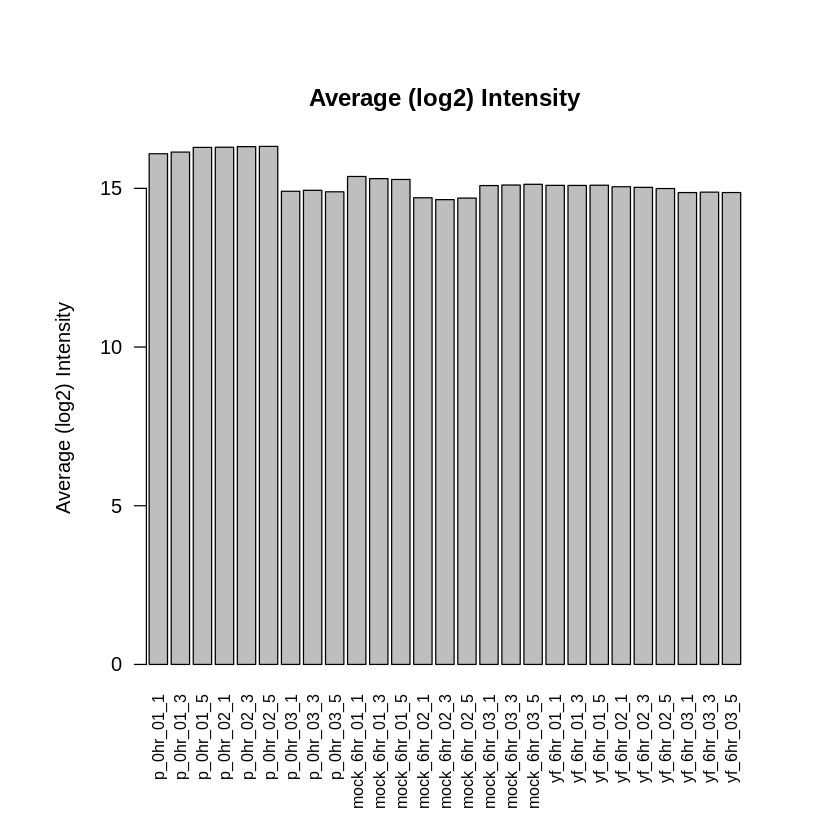

In [3]:
# Plotting ave intensity of each injection, for QC
par(mar=c(5.1,4.1,4.1,2.1),oma=c(2,2,2,2))
barplot(colMeans(data[,5:ncol(data)]), width = 0.8, main = "Average (log2) Intensity", 
        xlim=c(1,25), ylab = "Average (log2) Intensity", las = 2, cex.names=0.8)

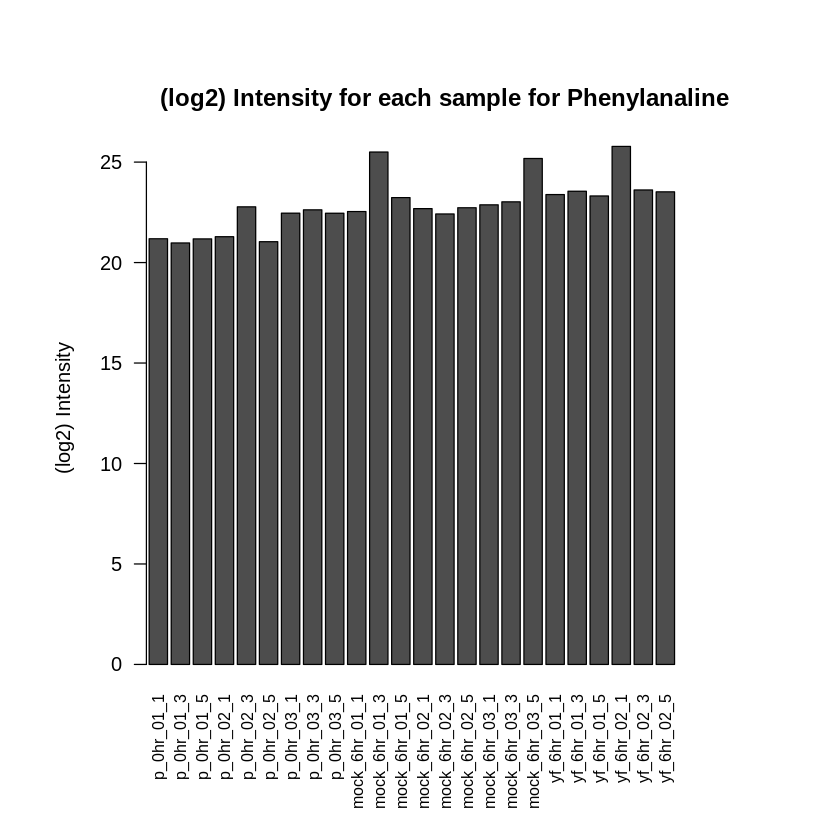

In [4]:
# example of phenylalanine here, which is consistently seen in human plasma using positive ESI on LC-MS.
# look for phenylalanine, 165.079 + H

phenylanaline <- subset(data,abs(data$mz -(165.079 + 1.0073)) < 0.002 )

par(mar=c(5.1,4.1,4.1,2.1),oma=c(2,2,2,2))
barplot(data.matrix(phenylanaline[1,5:28]), width = 0.8,
        main = "(log2) Intensity for each sample for Phenylanaline", xlim=c(1,25),
        ylab = "(log2) Intensity", las = 2, cex.names=0.8)


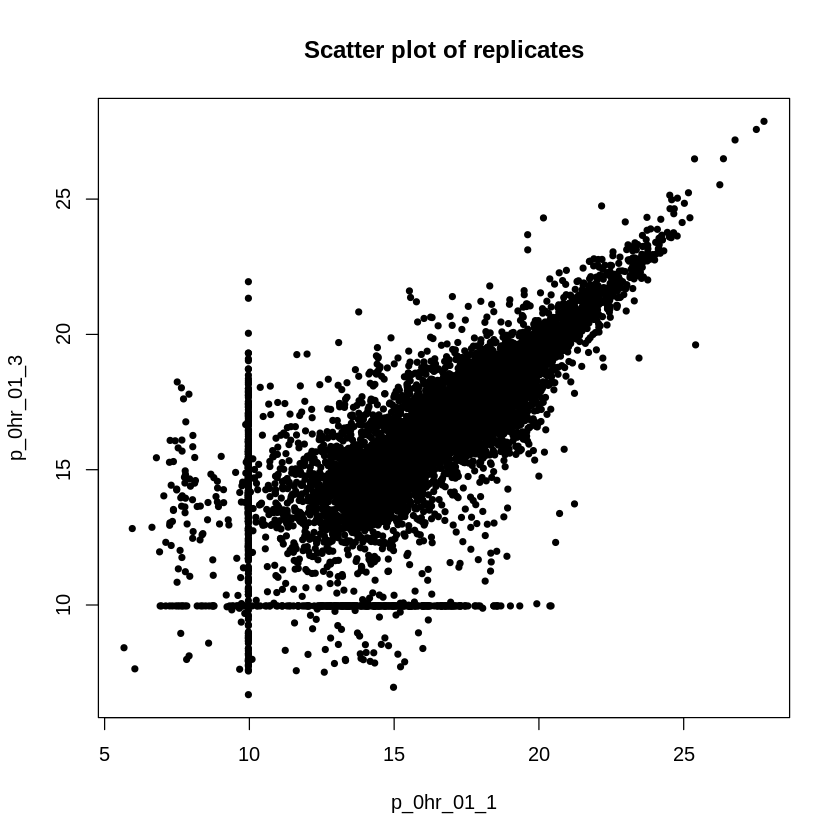

In [5]:
# reproducibility of injection replicates

plot(data.frame(data[5],data[6]), pch=20, main = "Scatter plot of replicates")

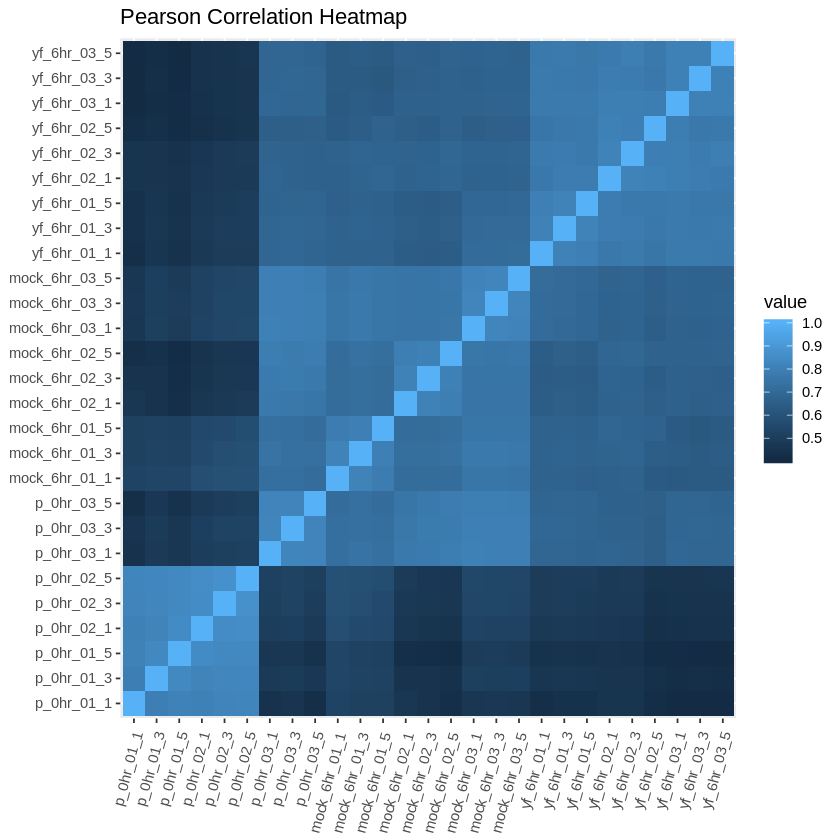

In [6]:
# Correlation of all pairs of injects/samples

newdata <- data[,5:ncol(data)]
CorrelationMatrix <- cor(newdata, method = "pearson")

MeltedData <- melt(CorrelationMatrix)
CorrelationMatrixPlot <- ggplot(data = MeltedData, aes(x=Var1, y=Var2, fill=value)) + 
                          geom_tile()+
                          theme(axis.text.x = element_text(angle = 75,  hjust = 1.05),
                                axis.title.x = element_blank(),axis.title.y = element_blank())+
                          ggtitle("Pearson Correlation Heatmap")

plot(CorrelationMatrixPlot)

If bad replicate or sample was spotted above, they should be removed from furhter processing.

We then take the average value of technical (injection) replicates, and use that as the value for one biological sample. For simplicity, this is not included in this notebook, but given in another notebook: http://mummichog.org/notebooks/Averaging_technical_replicates.html

## We are switching to another data table from now on for all the code below

In [7]:
# to scale each sample to the same mean intensity using only the most abundant features (e.g. 1000 here).

data2 <- read.delim("data/ave_log2_modc_ae_2012.txt", header = T)

data2$featureMeanIntensity <- rowMeans(newdata)
data2[order(-data2$featureMeanIntensity),]
top1000 <- data2[1:1000,]

NormalizedData <- data2
for (i in 3:ncol(data2)){
  NormalizedData[i] <- data2[i]*(colMeans(top1000[3])/colMeans(data2[i]))
           }

,mz,retention_time,mock_6hr_01,mock_6hr_02,mock_6hr_03,p_0hr_01,p_0hr_02,p_0hr_03,yf_6hr_01,yf_6hr_02,yf_6hr_03,featureMeanIntensity
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6256,239.10430,58,27.71,25.27,28.17,25.79,26.98,25.20,24.72,24.57,24.60,25.88921
1395,226.95060,49,26.31,26.11,25.67,23.87,24.45,25.39,25.87,25.84,26.27,25.53091
607,148.06010,66,25.78,25.78,25.87,23.56,24.05,24.98,25.67,25.67,25.53,25.20995
6329,477.20160,55,26.61,26.63,26.45,23.16,24.70,26.56,24.81,23.74,23.49,25.12817
27,90.97619,47,25.68,25.17,25.41,23.84,24.22,25.12,25.21,25.54,25.33,25.05694
7402,147.07590,59,24.80,26.77,26.22,23.33,23.58,25.96,24.41,23.78,25.12,24.88523
64,98.98341,527,25.32,24.78,25.03,24.99,25.16,24.68,24.76,24.62,24.34,24.85300
5013,158.96300,48,24.95,24.55,24.65,23.18,23.61,24.70,24.83,24.72,24.47,24.40691
1186,198.09660,65,23.90,23.88,23.59,27.01,27.16,23.53,23.20,23.51,23.40,24.35353


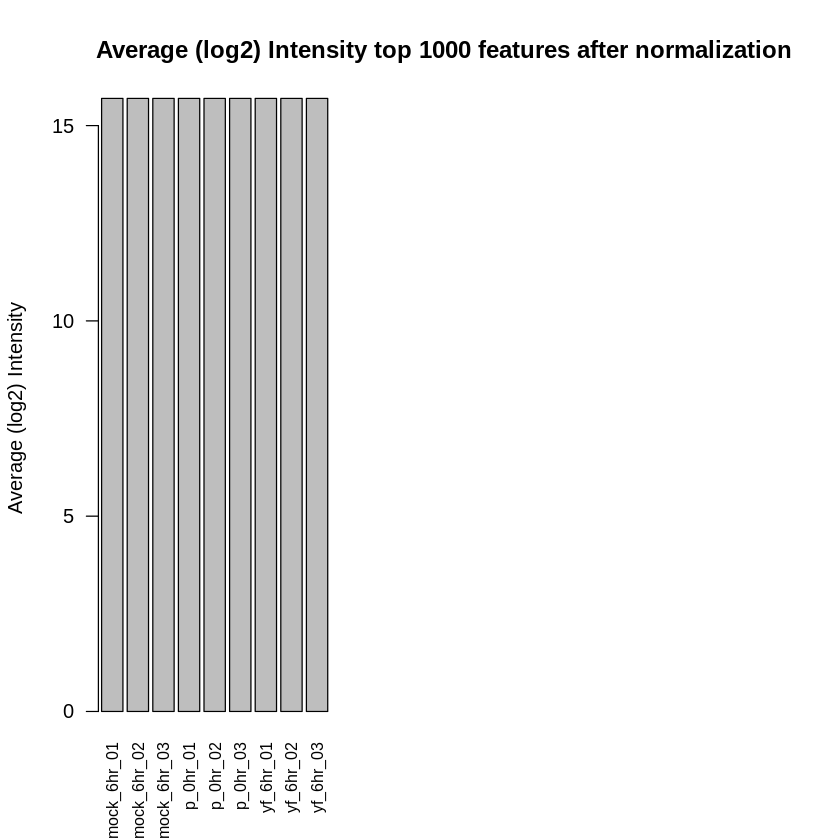

In [8]:
barplot(colMeans(NormalizedData[,3:(ncol(data2)-1)]), width = 0.8,
        main = "Average (log2) Intensity top 1000 features after normalization",
        xlim=c(1,25), ylab = "Average (log2) Intensity", las = 2,cex.names=0.8)

[1] "mock_6hr_01" "mock_6hr_02" "mock_6hr_03" "p_0hr_01"    "p_0hr_02"   
[6] "p_0hr_03"    "yf_6hr_01"   "yf_6hr_02"   "yf_6hr_03"

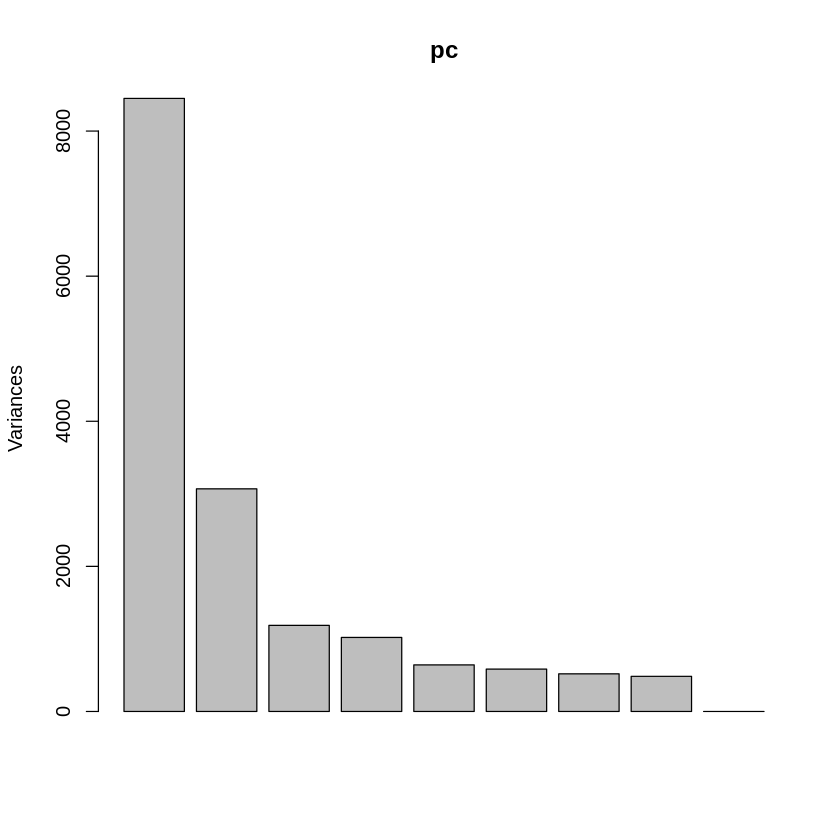

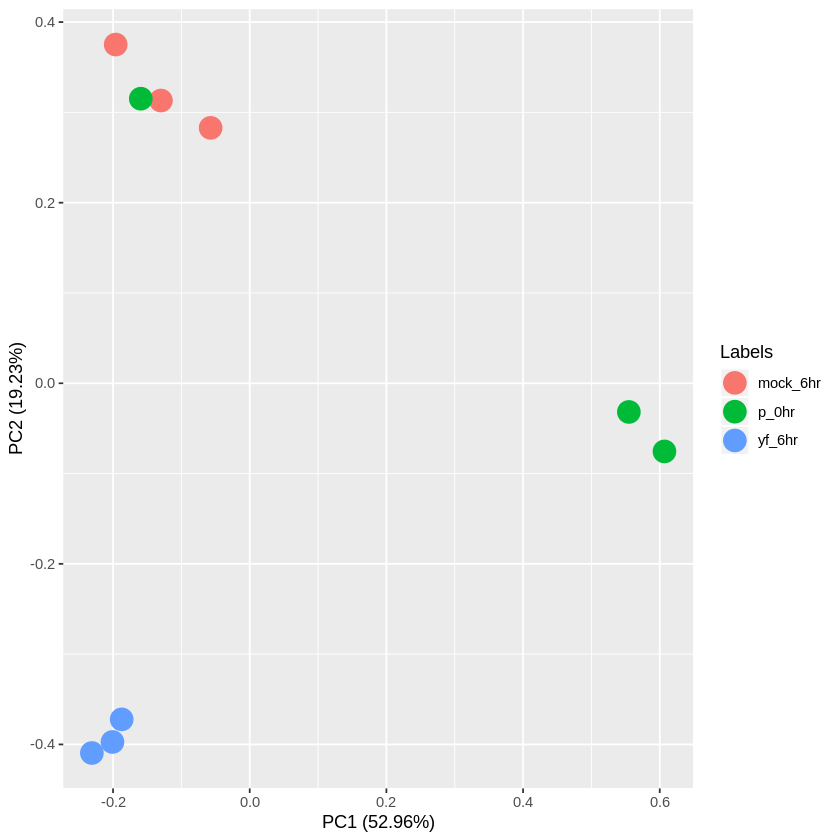

In [9]:
# PCA, principal component analysis, is an unsupervised method to explore data.
# Unusual patterns raise alarm for QC

TransposedData <- t(NormalizedData[,3:(ncol(NormalizedData)-1)])
TransposedDF <- data.frame(TransposedData)
pc <- prcomp(TransposedDF)

#graph showing influence of Principal components
plot(pc, type = "barplot")

row.names(TransposedData)
TransposedDF$Labels <- c("mock_6hr","mock_6hr","mock_6hr","p_0hr","p_0hr","p_0hr","yf_6hr","yf_6hr",
                           "yf_6hr" )

autoplot(pc, lable.size=10, data = TransposedDF, colour = 'Labels', size=6)

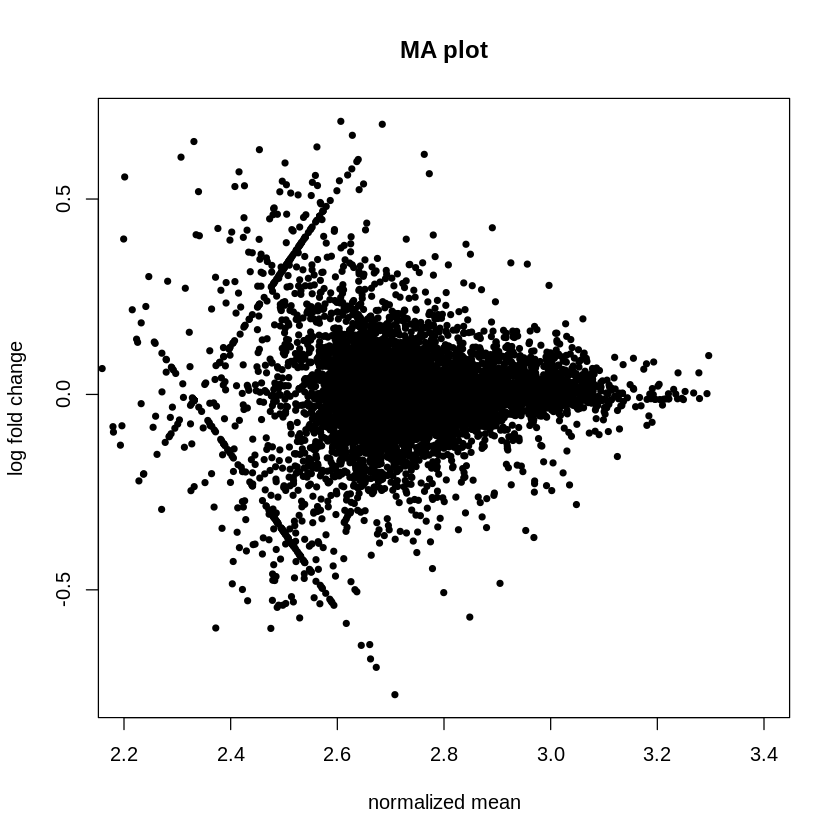

In [10]:
# MA plot can be used for QC, as the variance should not correlate with mean intensity

RemoveZeros <- NormalizedData
 RemoveZeros[RemoveZeros == 0] <- .001
 A <- log(RemoveZeros[3])-log(RemoveZeros[9])
 M <- log(RemoveZeros[3]*RemoveZeros[9])/2
      
 
 plot(data.frame(M,A),pch=20,main = "MA plot",xlab="normalized mean", 
           ylab="log fold change",xlim=(c(2.2,3.4)))


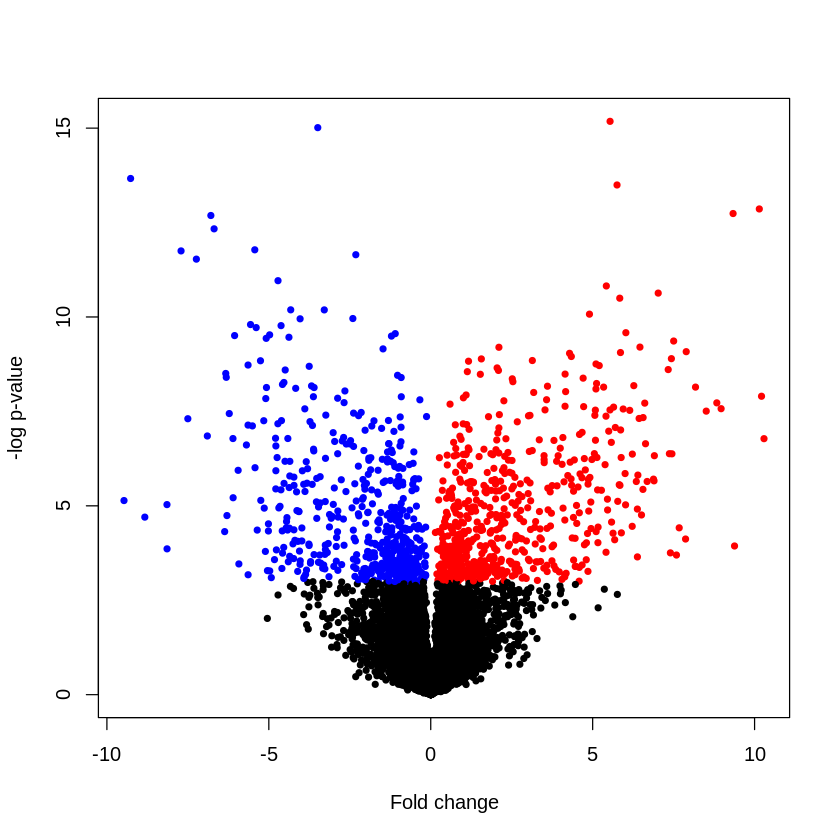

In [11]:
# Volcano plots are commonly used to visualize significance (p-value) vs magnitude (fold change)

mockandYF <- NormalizedData[c("mock_6hr_01","mock_6hr_02","mock_6hr_03","yf_6hr_01","yf_6hr_02","yf_6hr_03")]

getpvalues <- function(x){
  return(t.test(x[1:3],x[4:6])$p.value)
}

nomatches <- dplyr::filter(mockandYF, 
                           !(mock_6hr_01==mock_6hr_02 & mock_6hr_02 == mock_6hr_03 & 
                             yf_6hr_01== yf_6hr_02 & yf_6hr_02 ==yf_6hr_03  ) )

nomatches$pvalues <- apply(nomatches,1,getpvalues)
nomatches$foldchange <-  ((nomatches$mock_6hr_01-nomatches$yf_6hr_01) + 
                          (nomatches$mock_6hr_02-nomatches$yf_6hr_02) + 
                          (nomatches$mock_6hr_03-nomatches$yf_6hr_03))/3

plot(nomatches$foldchange, -log(nomatches$pvalues), pch=20,
     col= ifelse(nomatches$pvalues>0.05, "black", 
     ifelse(nomatches$foldchange<0,"blue","red")),
     xlab="Fold change", ylab="-log p-value"
    )


Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



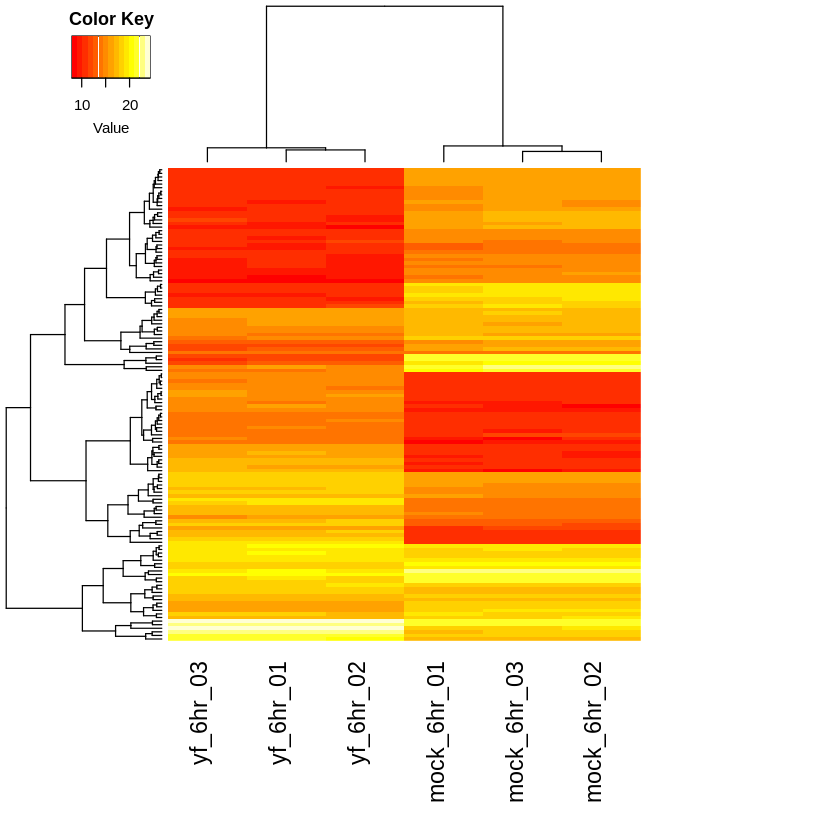

In [15]:
# make heatmap on feafures with FDR < 0.05
require(gplots)
nomatches$qvalue <- p.adjust(nomatches$pvalues, "BH")
FDRfiltered <- subset(nomatches, qvalue<0.05 )
heatmap.2(as.matrix(FDRfiltered[,1:6]), keysize=1, margins = c(10, 10),
          cexCol = 1.4, labRow = FALSE, trace='none', density.info='none')
